In [17]:
# Cell 1: Setup and Library Installation

.libPaths(c("~/BIOL616-FinalProject-Repo/Rlibs", .libPaths())) #Initialize R library path

if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager", lib = "~/BIOL616-FinalProject-Repo/Rlibs")
}

install.packages("ggplot2", lib = "~/BIOL616-FinalProject-Repo/Rlibs")
install.packages("data.table", lib = "~/BIOL616-FinalProject-Repo/Rlibs") 
install.packages("cowplot", lib = "~/BIOL616-FinalProject-Repo/Rlibs") 
BiocManager::install("ComplexHeatmap", lib = "~/BIOL616-FinalProject-Repo/Rlibs") 

suppressPackageStartupMessages({
    library(ggplot2)      
    library(ComplexHeatmap) 
    library(circlize)     
    library(data.table)  
})

cat("All necessary visualization libraries loaded.\n")



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.0 (2022-04-22)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ComplexHeatmap'”


All necessary visualization libraries loaded.


In [18]:
# Cell 2: Define Paths and Load DEG Results

# Input Paths
deg_fp    <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals.csv"
expr_fp   <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/preprocessing_outputs/expr_LumA_IDC_Tumor_vs_AllNormals.tsv"
meta_fp   <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/preprocessing_outputs/metadata_LumA_IDC_Tumor_vs_AllNormals.tsv"

# Output Paths
annot_fp  <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_annotated.csv"
volcano_png <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/Volcano_LumA_IDC_Tumor_vs_AllNormals.png"
out_png_up    <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_top10_Up_in_Tumor.png"
out_png_down  <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_top10_Down_in_Tumor.png"
out_heatmap_png <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.png"
out_heatmap_pdf <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.pdf"

# Load DEG table
deg <- read.csv(deg_fp, stringsAsFactors = FALSE)
deg <- deg[!is.na(deg$pvalue) & !is.na(deg$padj), ]
cat("DEG table loaded:", nrow(deg), "genes.\n")

DEG table loaded: 20530 genes.


In [60]:
# Cell 3: Annotate and Resave DEG Table

# Thresholds
padj_cutoff    <- 0.05
log2fc_cutoff <- 1

# Annotate: -log10(padj) and regulation class
deg$negLog10Padj <- -log10(deg$padj)

deg$Regulation <- "Not Significant"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange >  log2fc_cutoff] <- "Up"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange < -log2fc_cutoff] <- "Down"

deg$Regulation <- factor(deg$Regulation, levels = c("Down","Not Significant","Up"))

cat("DE gene counts (padj <", padj_cutoff, ", |log2FC| >", log2fc_cutoff, "):\n")
print(table(deg$Regulation))

# Save annotated DEG table
write.csv(deg, annot_fp, row.names = FALSE)
cat("Annotated DEG table written to:\n  ", annot_fp, "\n")

# Recreate ranked list 
deg$score <- sign(deg$log2FoldChange) * -log10(deg$pvalue)
deg_ranked <- deg[order(deg$score, decreasing = TRUE), ]
rnk_fp <- gsub("annotated.csv", "rnk", annot_fp) 

write.table(
    deg_ranked[, c("gene", "score")],
    rnk_fp,
    sep = "\t",
    col.names = FALSE,
    row.names = FALSE,
    quote = FALSE
)
cat("Ranked .rnk file written to:\n  ", rnk_fp, "\n")

DE gene counts (padj < 0.05 , |log2FC| > 1 ):

           Down Not Significant              Up 
           2770           16339            1421 
Annotated DEG table written to:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_annotated.csv 
Ranked .rnk file written to:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_rnk 


Labeling top 25 upregulated and top 25 downregulated genes (Total: 50 genes).
Volcano plot saved to:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/Volcano_LumA_IDC_Tumor_vs_AllNormals.png 


# Top 50 Genes Labeled on Volcano Plot


Table: The 50 most significant DEGs (FDR < 0.05, |log2FC| > 1) sorted by adjusted FDR.

| Rank |Gene       | log2FoldChange |   padj    | Regulation |
|:----:|:----------|:--------------:|:---------:|:----------:|
|  1   |COL10A1    |      7.69      | 4.56e-167 |     Up     |
|  2   |MMP11      |      6.38      | 5.22e-149 |     Up     |
|  3   |NEK2       |      4.12      | 5.82e-108 |     Up     |
|  4   |PPAPDC1A   |      5.40      | 2.65e-106 |     Up     |
|  5   |COL11A1    |      6.71      | 7.52e-104 |     Up     |
|  6   |GABRD      |      3.38      | 2.91e-103 |     Up     |
|  7   |HSD17B6    |      3.14      | 4.24e-103 |     Up     |
|  8   |WISP1      |      3.79      | 6.35e-101 |     Up     |
|  9   |BMP8A      |      

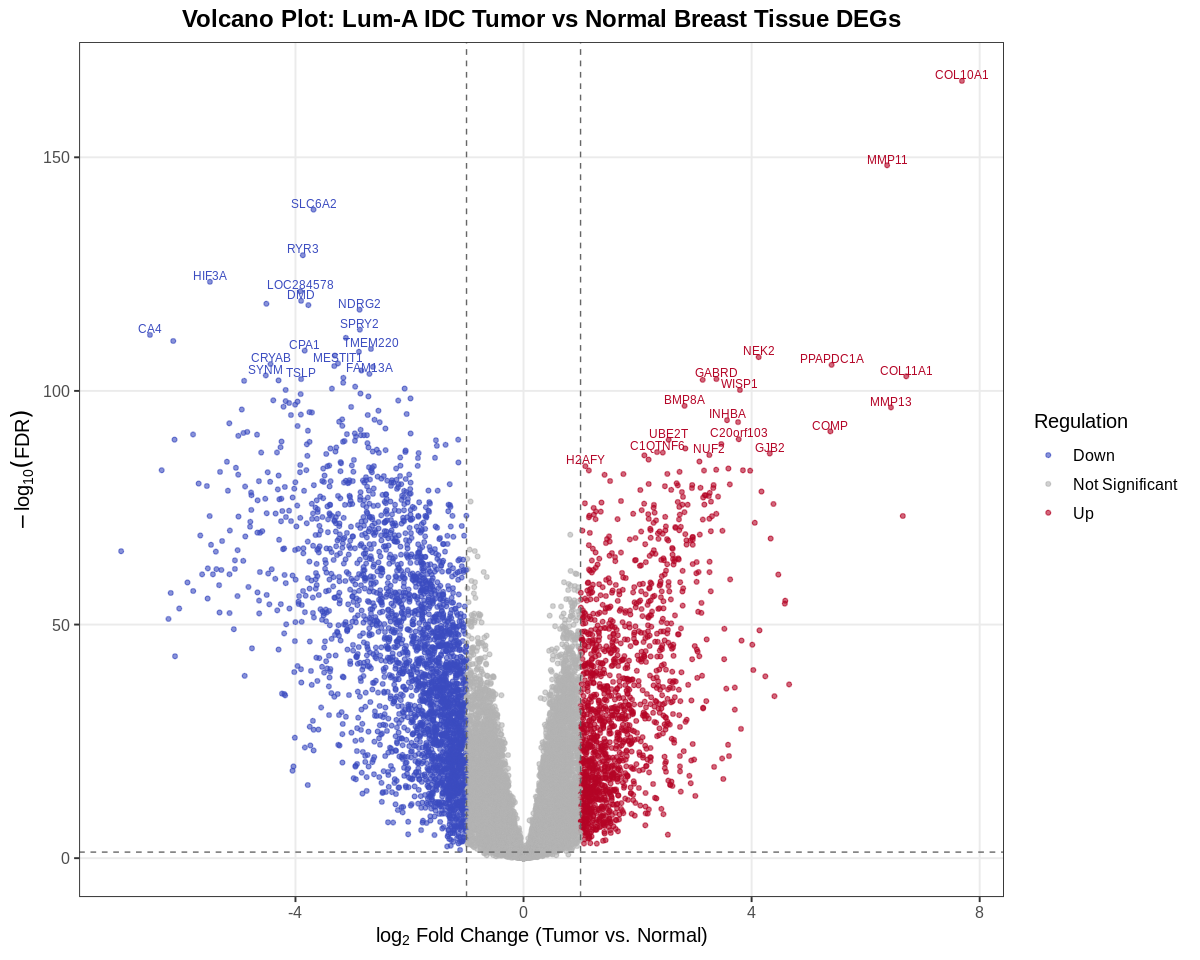

In [66]:
# Cell 4: Generate and Save Volcano Plot using ggplot2

# UPDATED: Define labeling logic for Top 25 Up and Top 25 Down 

# Separate significant DEGs by direction
deg_sig_up <- deg[deg$Regulation == "Up" & deg$padj < padj_cutoff & abs(deg$log2FoldChange) > log2fc_cutoff, ]
deg_sig_down <- deg[deg$Regulation == "Down" & deg$padj < padj_cutoff & abs(deg$log2FoldChange) > log2fc_cutoff, ]

# Sort by significance (padj) for each direction
deg_sig_up <- deg_sig_up[order(deg_sig_up$padj), ]
deg_sig_down <- deg_sig_down[order(deg_sig_down$padj), ]

# Select the top 25 from each direction (or fewer if less than 25 are available)
n_label_per_side <- 25
top_up <- deg_sig_up[1:min(n_label_per_side, nrow(deg_sig_up)), ]
top_down <- deg_sig_down[1:min(n_label_per_side, nrow(deg_sig_down)), ]

# Combine the lists for labeling
label_genes <- rbind(top_up, top_down)
n_label <- nrow(label_genes)

cat("Labeling top", n_label_per_side, "upregulated and top", n_label_per_side, "downregulated genes (Total:", n_label, "genes).\n")

# Volcano plot construction (No change needed here, it uses label_genes) 
p <- ggplot(deg, aes(x = log2FoldChange, y = negLog10Padj, color = Regulation)) +
    geom_point(alpha = 0.6, size = 1) +
    # Threshold lines
    geom_vline(xintercept = c(-log2fc_cutoff, log2fc_cutoff),
               linetype = "dashed", 
               linewidth = 0.4, 
               color = "grey40") +
    geom_hline(yintercept = -log10(padj_cutoff),
               linetype = "dashed", 
               linewidth = 0.4, 
               color = "grey40") +
    # Gene labels
    geom_text(
        data = label_genes, # Uses the new combined list
        aes(label = gene),
        size = 2.5,
        vjust = -0.2,
        check_overlap = TRUE, # When line is active, if label overlaps it isnt plotted
        show.legend = FALSE
    ) +
    scale_color_manual(values = c(
        "Down"  = "#3B4CC0",
        "Not Significant" = "grey70",
        "Up"    = "#B40426"
    )) +
    labs(
        title = "Volcano Plot: Lum-A IDC Tumor vs Normal Breast Tissue DEGs",
        x = log[2] ~ "Fold Change (Tumor vs. Normal)",
        y = expression(-log[10]("FDR")),
        color = "Regulation"
    ) +
    theme_bw(base_size = 12) +
    theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        panel.grid.minor = element_blank()
    )

# Save plot
ggsave(volcano_png, p, width = 8, height = 5, dpi = 300)
cat("Volcano plot saved to:\n  ", volcano_png, "\n")

# Show volcano in output
print(p)

# Table generation (Updated to use the new n_label and label_genes)
# Create table for top significant DEGs
if (!requireNamespace("knitr", quietly = TRUE)) {
    install.packages("knitr", lib = "~/BIOL616-FinalProject-Repo/Rlibs")
}
library(knitr, lib.loc = "~/BIOL616-FinalProject-Repo/Rlibs")

# Create a data frame for printing
table_data <- data.frame(
    Rank = 1:n_label,
    Gene = label_genes$gene,
    log2FoldChange = round(label_genes$log2FoldChange, 2),
    padj = formatC(label_genes$padj, format = "e", digits = 2), # Format p-value in scientific notation
    Regulation = label_genes$Regulation,
    stringsAsFactors = FALSE
)

# Print the table using kable() for clean Markdown formatting
cat("\n\n")
cat("# Top", n_label, "Genes Labeled on Volcano Plot\n")
print(
    kable(
        table_data, 
        align = c("c", "l", "c", "c", "c"),
        caption = paste("The", n_label, "most significant DEGs (FDR < 0.05, |log2FC| > 1) sorted by adjusted FDR.")
    )
)

In [21]:
# Cell 5: Merge GSEA Output Files

# KEGG Legacy Paths
kegg_legacy_pos_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Legacy/gsea_report_for_na_pos_1764644573051.tsv"
kegg_legacy_neg_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Legacy/gsea_report_for_na_neg_1764644573051.tsv"

# KEGG Medicus Paths
kegg_medicus_pos_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Medicus/gsea_report_for_na_pos_1764645583710.tsv"
kegg_medicus_neg_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Medicus/gsea_report_for_na_neg_1764645583710.tsv"

# Hallmark Paths
hallmark_pos_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/Hallmark-All/gsea_report_for_na_pos_1763154663293.tsv"
hallmark_neg_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/Hallmark-All/gsea_report_for_na_neg_1763154663293.tsv"

# Helper Function to Load and Annotate
load_gsea_reports <- function(pos_fp, neg_fp, db_name) {
    # Load Positive Enrichment (Upreg in Tumor)
    pos <- read.delim(pos_fp, stringsAsFactors = FALSE)
    pos$direction <- "Up_in_Tumor"
    pos$Database <- db_name

    # Load Negative Enrichment (Downreg in Tumor)
    neg <- read.delim(neg_fp, stringsAsFactors = FALSE)
    neg$direction <- "Down_in_Tumor"
    neg$Database <- db_name

    return(rbind(pos, neg))
}

# Load and Combine All Three Databases
gsea_legacy <- load_gsea_reports(kegg_legacy_pos_fp, kegg_legacy_neg_fp, "KEGG_Legacy")
gsea_medicus <- load_gsea_reports(kegg_medicus_pos_fp, kegg_medicus_neg_fp, "KEGG_Medicus")
gsea_hallmark <- load_gsea_reports(hallmark_pos_fp, hallmark_neg_fp, "Hallmark")

# Combine all results into one master data frame
gsea_all <- rbind(gsea_legacy, gsea_medicus, gsea_hallmark)

# Sort by NES descending (Normalized Enrichment Score)
gsea_all <- gsea_all[order(gsea_all$NES, decreasing = TRUE), ]

# Save combined summary
out_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_ALL_summary_LumA_IDC_Tumor_vs_AllNormals.csv"
write.csv(gsea_all, out_fp, row.names = FALSE)
cat("Wrote combined GSEA summary to:\n  ", out_fp, "\n")

head(gsea_all[, c("NAME", "Database", "NES", "FDR.q.val", "direction")], 15)

Wrote combined GSEA summary to:
   ~/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_ALL_summary_LumA_IDC_Tumor_vs_AllNormals.csv 


,NAME,Database,NES,FDR.q.val,direction
,<chr>,<chr>,<dbl>,<dbl>,<chr>
177,KEGG_MEDICUS_REFERENCE_ORIGIN_UNWINDING_AND_ELONGATION,KEGG_Medicus,2.158563,0.0000000000,Up_in_Tumor
1,KEGG_PROTEASOME,KEGG_Legacy,2.139744,0.0000000000,Up_in_Tumor
2,KEGG_DNA_REPLICATION,KEGG_Legacy,2.137784,0.0000000000,Up_in_Tumor
3,KEGG_BASE_EXCISION_REPAIR,KEGG_Legacy,2.065026,0.0000000000,Up_in_Tumor
4,KEGG_CELL_CYCLE,KEGG_Legacy,2.060763,0.0000000000,Up_in_Tumor
178,KEGG_MEDICUS_VARIANT_MUTATION_CAUSED_ABERRANT_HTT_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION,KEGG_Medicus,2.055046,0.0005537635,Up_in_Tumor
179,KEGG_MEDICUS_REFERENCE_PRE_IC_FORMATION,KEGG_Medicus,2.043467,0.0007930439,Up_in_Tumor
180,KEGG_MEDICUS_VARIANT_MUTATION_CAUSED_ABERRANT_ABETA_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION,KEGG_Medicus,2.021111,0.0005947830,Up_in_Tumor
181,KEGG_MEDICUS_REFERENCE_HOMOLOGOUS_RECOMBINATION,KEGG_Medicus,2.013761,0.0004758264,Up_in_Tumor


Saved waterfall GSEA plot for KEGG_Medicus → ~/BIOL616-FinalProject-Repo/datasets/GSEA_output//GSEA_Waterfall_KEGG_Medicus.png.
Saved waterfall GSEA plot for KEGG_Legacy → ~/BIOL616-FinalProject-Repo/datasets/GSEA_output//GSEA_Waterfall_KEGG_Legacy.png.


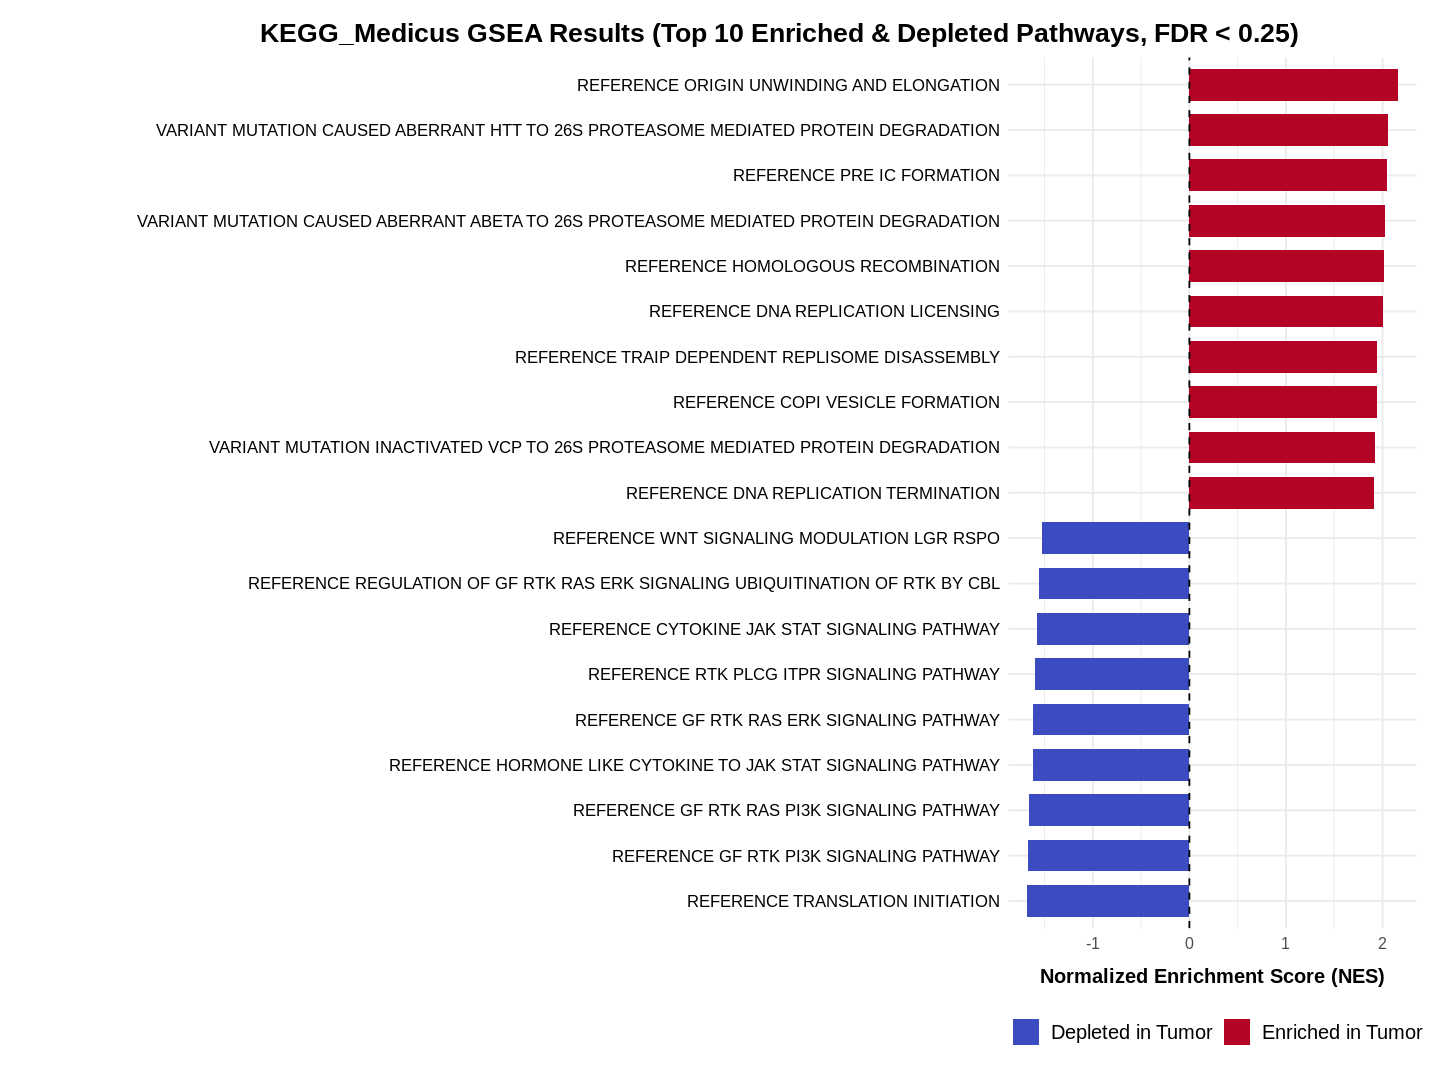

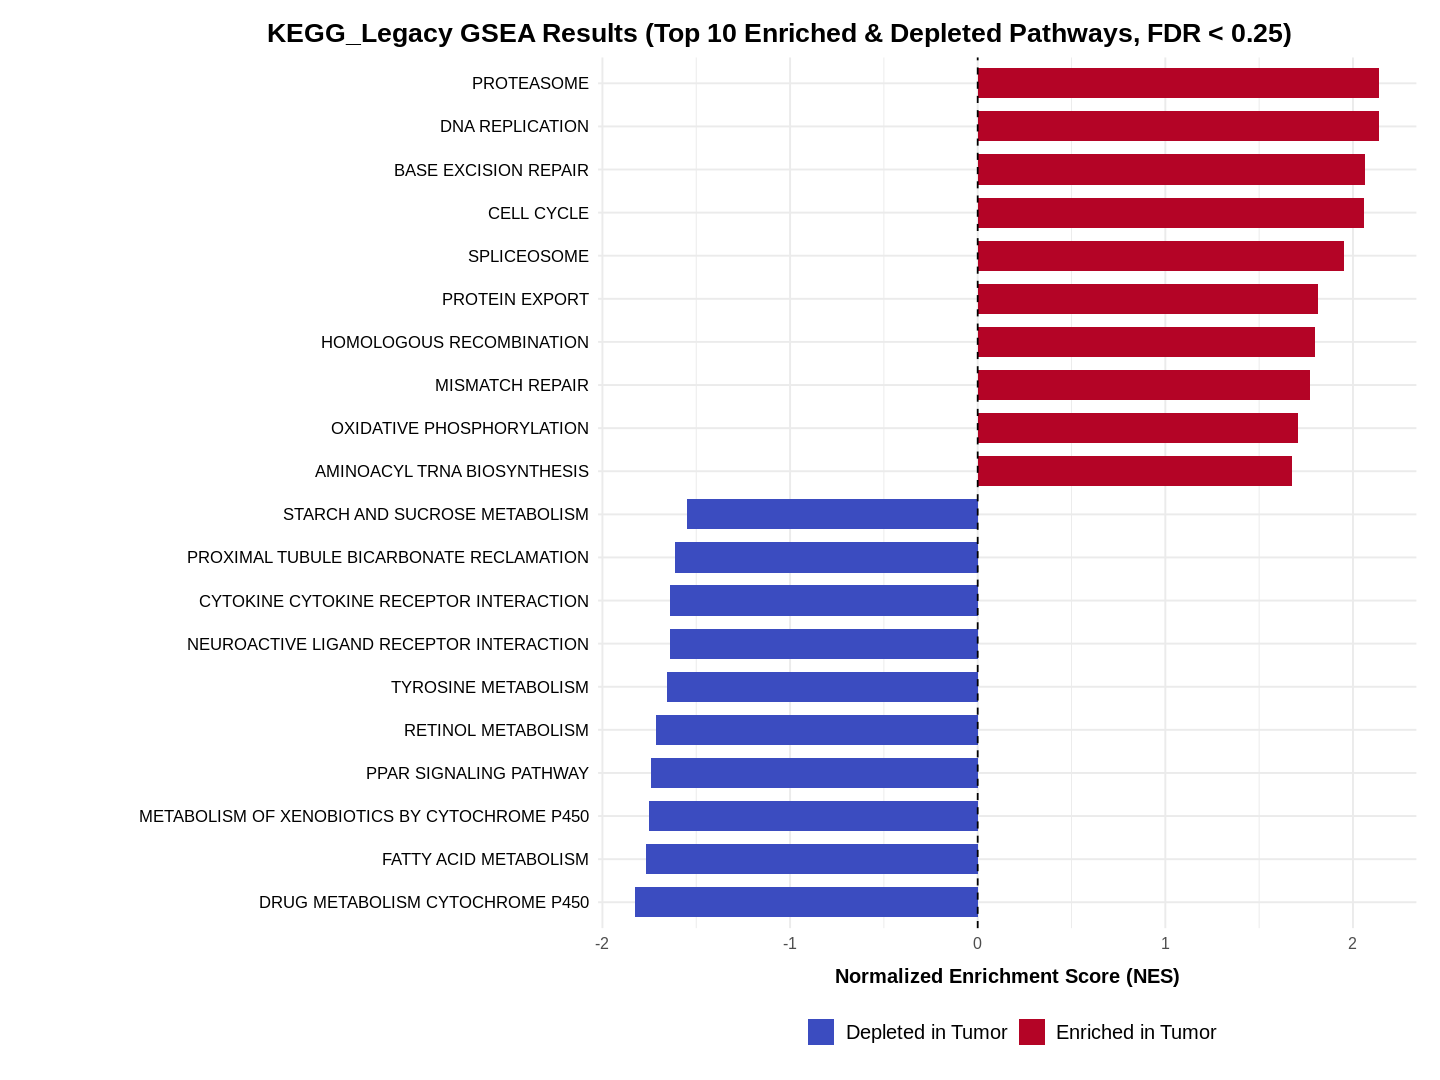

Saved waterfall GSEA plot for Hallmark → ~/BIOL616-FinalProject-Repo/datasets/GSEA_output//GSEA_Waterfall_Hallmark.png.

All waterfall GSEA barplots saved and displayed.


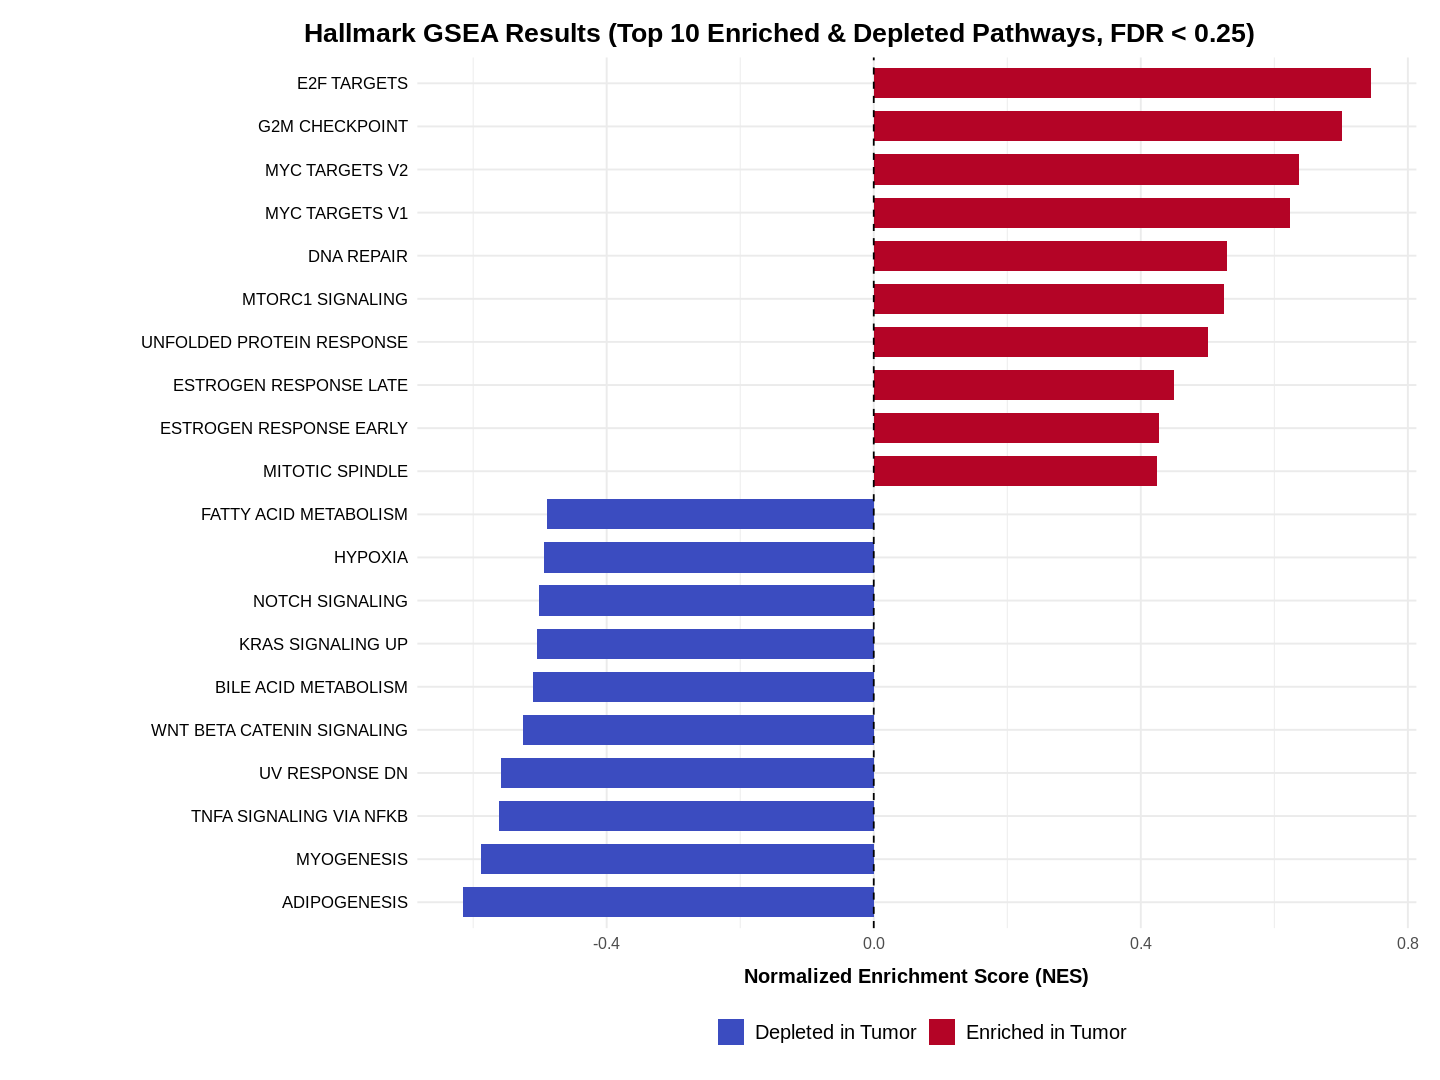

In [48]:
# Cell 6: Generate GSEA Combined Barplots (Single Plot, Horizontal Display)

# ... (Database and directory definitions remain the same) ...
library(ggplot2)
library(cowplot)

databases_to_plot <- unique(gsea_all$Database)
out_dir <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/" 
PLOT_WIDTH <- 11  
PLOT_HEIGHT <- 8.0 

# Loop through each database to create combined plots
for (db_name in databases_to_plot) {
    
    # ... (Steps 1 and 2 for filtering and sorting remain the same) ...
    gsea_db_sig <- gsea_all[gsea_all$Database == db_name & gsea_all$FDR.q.val < 0.25, ]
    
    gsea_up <- gsea_db_sig[gsea_db_sig$direction == "Up_in_Tumor", ]
    gsea_up <- gsea_up[order(gsea_up$NES, decreasing = TRUE), ]
    top_up  <- gsea_up[1:min(10, nrow(gsea_up)), ]
    
    gsea_down <- gsea_db_sig[gsea_db_sig$direction == "Down_in_Tumor", ]
    gsea_down <- gsea_down[order(gsea_down$NES, decreasing = FALSE), ]
    top_down  <- gsea_down[1:min(10, nrow(gsea_down)), ]
    
    gsea_combined <- rbind(top_up, top_down)
    
    gsea_combined$SHORT_NAME <- gsub("^(KEGG_|MEDICUS_|HALLMARK_|REACTOME_|REFERENCE\\s?)", "", gsea_combined$NAME)
    gsea_combined$SHORT_NAME <- gsub("_", " ", gsea_combined$SHORT_NAME)
    gsea_combined$SHORT_NAME <- gsub("^MEDICUS\\s?", "", gsea_combined$SHORT_NAME)
    
    gsea_combined$SHORT_NAME <- factor(gsea_combined$SHORT_NAME, 
                                        levels = gsea_combined$SHORT_NAME[order(gsea_combined$NES)])
    
    # 3. Generate the Combined Waterfall Plot
    p_waterfall <- ggplot(gsea_combined, aes(x = SHORT_NAME, y = NES, fill = direction)) +
        
        geom_col(width = 0.7) +
        coord_flip() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", linewidth = 0.5) +
        
        scale_fill_manual(
            values = c("Up_in_Tumor" = "#B40426", "Down_in_Tumor" = "#3B4CC0"),
            labels = c("Depleted in Tumor", "Enriched in Tumor"),
            name = "" 
        ) +
        
        labs(
            title = paste0(db_name, " GSEA Results (Top 10 Enriched & Depleted Pathways, FDR < 0.25)"),
            x = "", 
            y = "Normalized Enrichment Score (NES)" # This is the label being clipped
        ) +
        
        theme_minimal(base_size = 12) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
            plot.title.position = "plot", 
            
            # 🚨 KEY FIX 1: Remove the Y-axis label text (which is actually the NES label due to coord_flip)
            axis.title.y = element_blank(),
            
            # 🚨 KEY FIX 2: Manually adjust the X-axis title (which is the pathway name label)
            axis.title.x = element_text(face = "bold", size = 12, margin = margin(t = 10)),
            
            axis.text.y = element_text(size = 10, colour = "black"),
            legend.position = "bottom", 
            legend.text = element_text(size = 12),
            
            # Revert margins to reasonable values, removing the need for extreme numbers
            # (Top, Right, Bottom, Left)
            plot.margin = unit(c(0.5, 0.5, 0.5, 3.0), "cm") 
        )
    
    # We must explicitly redefine the X-axis label (which is the NES axis)
    # The pathway name label (Y-axis title) remains blank/removed.
    p_waterfall <- p_waterfall + labs(x = "Normalized Enrichment Score (NES)")


    # 4. Save and Display Plot
    out_png_waterfall <- file.path(out_dir, paste0("GSEA_Waterfall_", db_name, ".png"))
    
    ggsave(out_png_waterfall, p_waterfall, width = PLOT_WIDTH, height = PLOT_HEIGHT, dpi = 300)
    
    options(repr.plot.width = 12, repr.plot.height = 9) 
    print(p_waterfall)
    
    cat(paste0("Saved waterfall GSEA plot for ", db_name, " → ", out_png_waterfall, ".\n"))
}

cat("\nAll waterfall GSEA barplots saved and displayed.\n")
options(repr.plot.width = 7, repr.plot.height = 4)

In [23]:
# Cell 7: Heatmap: Prepare Data and Annotations

# Save significant DEGs
deg_sig <- deg[deg$padj < padj_cutoff & abs(deg$log2FoldChange) > log2fc_cutoff, ]

# Top 25 up and top 25 down by padj
deg_up    <- deg_sig[deg_sig$log2FoldChange > 0, ]
deg_down <- deg_sig[deg_sig$log2FoldChange < 0, ]

deg_up    <- deg_up[order(deg_up$padj), ][1:min(25, nrow(deg_up)), ]
deg_down <- deg_down[order(deg_down$padj), ][1:min(25, nrow(deg_down)), ]

genes_top  <- unique(c(deg_up$gene, deg_down$gene))
genes_top <- genes_top[genes_top %in% rownames(expr)] # Ensure genes are in the expression matrix

cat("Heatmap includes", length(genes_top), "total DEGs (up and down).\n")

# Load expression matrix (using data.table::fread) 
expr_dt <- data.table::fread(expr_fp, check.names = FALSE)
expr <- as.data.frame(expr_dt)
rownames(expr) <- expr[[1]]
expr <- expr[,-1]

# Load metadata
meta <- read.csv(meta_fp, stringsAsFactors = FALSE, check.names = FALSE)

# --- Define ID Normalization Function 
normalize_ids <- function(x) {
    x <- as.character(x)
    x <- gsub("\\.", "-", x)
    x <- substr(x, 1, 15) # Standard TCGA barcode length
    return(x)
}

# Apply Normalization and Alignment
colnames(expr) <- normalize_ids(colnames(expr))
meta$Sample_norm <- normalize_ids(meta$Sample)
rownames(meta) <- meta$Sample_norm

common_samples <- intersect(colnames(expr), rownames(meta))

if (length(common_samples) < 2) {
    stop("Fewer than 2 overlapping samples after ID normalization. Cannot proceed with heatmap.")
}

expr_sub <- expr[genes_top, common_samples, drop = FALSE]
meta_sub <- meta[common_samples, , drop = FALSE]

# Scale rows (Z-score)
expr_scaled <- t(scale(t(expr_sub)))

Heatmap includes 50 total DEGs (up and down).


pdf 
  2

pdf 
  2

Saved heatmap:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.png 
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.pdf 


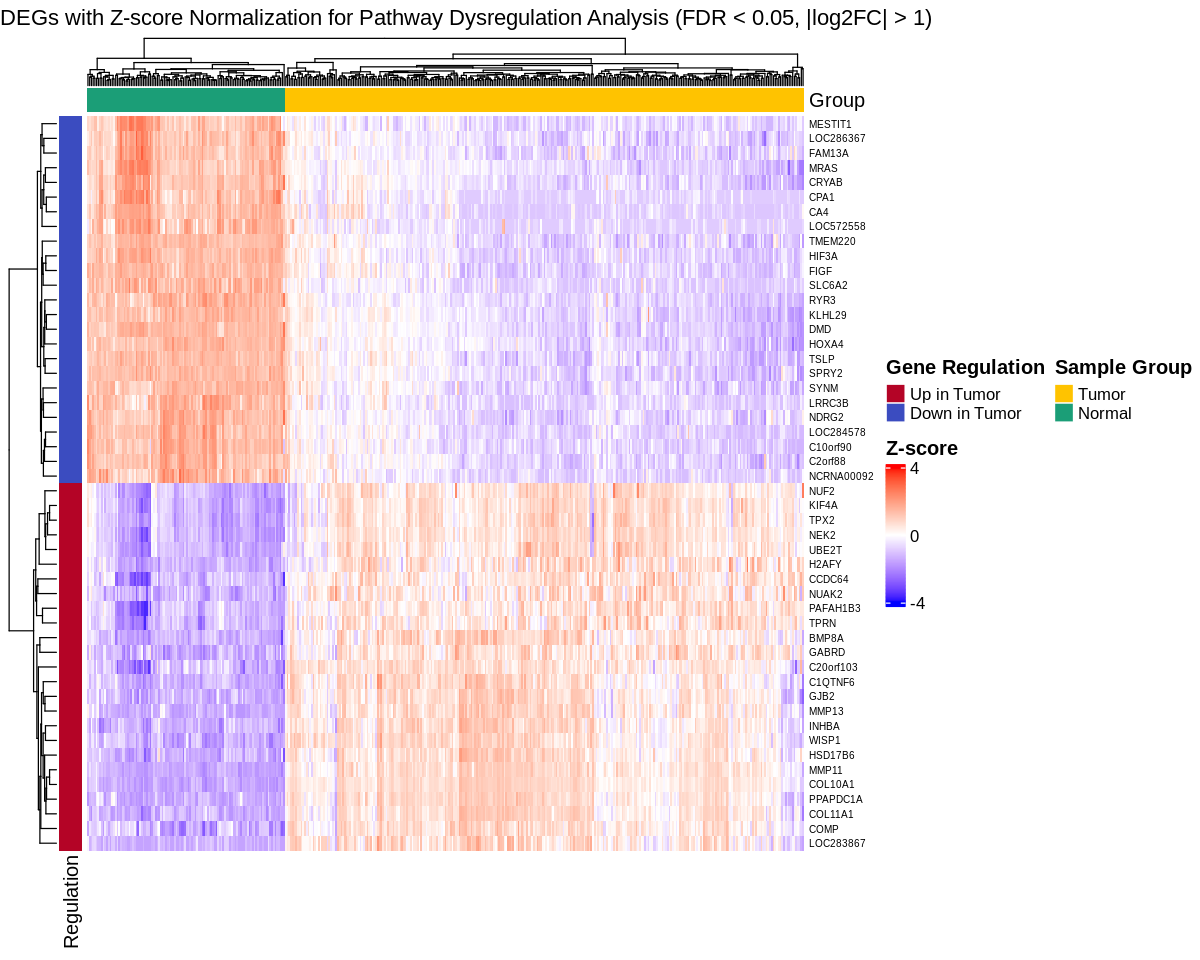

In [54]:
# Cell 8: Generate and Save Heatmap (Finalized with Legend Control)

# Define Colors 
SAMPLE_TUMOR_COLOR <- "#FFC300" # Yellow/Gold
SAMPLE_NORMAL_COLOR <- "#1B9E77" # Teal/Green
REGULATION_UP_COLOR <- "#B40426" # Red
REGULATION_DOWN_COLOR <- "#3B4CC0" # Blue

# Define Annotations (ha_col and ha_row)

sample_group <- meta_sub$Group
names(sample_group) <- rownames(meta_sub)

# Column Annotation (Sample Group: Tumor vs. Normal)
ha_col <- HeatmapAnnotation(
    Group = sample_group,
    col = list(Group = c("Tumor" = SAMPLE_TUMOR_COLOR, "Normal" = SAMPLE_NORMAL_COLOR)),
    # Define parameters for the 'Group' legend
    annotation_legend_param = list(
        Group = list(
            title = "Sample Group",
            title_gp = gpar(fontface = "bold"),
            at = c("Tumor", "Normal"),
            labels = c("Tumor", "Normal")
        )
    )
)

row_reg <- ifelse(rownames(expr_scaled) %in% deg_up$gene, "Up_in_Tumor", "Down_in_Tumor")

# Row Annotation (Gene Regulation Status: Up vs. Down)
ha_row <- rowAnnotation(
    Regulation = row_reg,
    col = list(Regulation = c("Up_in_Tumor" = REGULATION_UP_COLOR, "Down_in_Tumor" = REGULATION_DOWN_COLOR)),
    # Define parameters for the 'Regulation' legend
    annotation_legend_param = list(
        Regulation = list(
            title = "Gene Regulation",
            title_gp = gpar(fontface = "bold"),
            at = c("Up_in_Tumor", "Down_in_Tumor"),
            labels = c("Up in Tumor", "Down in Tumor")
        )
    )
)

# Heatmap Construction

# Define the color mapping for the expression matrix (Z-score)
EXPR_COLORS <- colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))

h <- Heatmap(
    expr_scaled,
    name = "Z-score",
    col = EXPR_COLORS, # Apply the defined color scale
    
    # Annotations
    top_annotation = ha_col,
    left_annotation = ha_row,
    
    # Clustering and display options
    show_row_names = TRUE,
    show_column_names = FALSE,
    cluster_rows = TRUE,
    cluster_columns = TRUE,
    row_names_gp = gpar(fontsize = 6),
    column_title = "Top DEGs with Z-score Normalization for Pathway Dysregulation Analysis (FDR < 0.05, |log2FC| > 1)",
    
    # Define parameters for the main expression legend
    heatmap_legend_param = list(
        title = "Z-score",
        title_gp = gpar(fontface = "bold"),
        at = c(-4, 0, 4), 
        labels = c("-4", "0", "4"),
        legend_height = unit(3, "cm")
    )
)

# Save Plots (Using the draw() function for controlled output) 

dir.create(dirname(out_heatmap_png), recursive = TRUE, showWarnings = FALSE)

# Save as PNG
png(out_heatmap_png, width = 2000, height = 1500, res = 200)
# Use draw() to explicitly control legend side for a clean image file
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

# Save as PDF
pdf(out_heatmap_pdf, width = 12, height = 10)
# Use draw() for PDF output as well
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")
dev.off()

# Print the heatmap directly in the notebook cell output for review
options(repr.plot.width = 10, repr.plot.height = 8)
draw(h, heatmap_legend_side = "right", annotation_legend_side = "right")

cat("Saved heatmap:\n  ", out_heatmap_png, "\n  ", out_heatmap_pdf, "\n")